# Breast Ultrasound Dataset - Feature Extraction & Train/Test Split
## Multimodal Classification Preparation

This notebook prepares the breast ultrasound dataset by:
1. Loading and exploring the dataset
2. Extracting multiple types of features from images
3. Separating train and test datasets
4. Preparing data for multimodal classification

### Note on Image Modalities:
- **Ultrasound (US)**: Sound waves, grayscale, detailed soft tissue, high speckle noise
- **X-ray/Mammography**: Electromagnetic radiation, grayscale, dense tissue contrast, less noise
- **CT**: Cross-sectional, 3D volumetric data
- **MRI**: Magnetic fields, multi-sequence, excellent soft tissue contrast


## 1. Install and Import Required Libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## 2. Load and Explore Dataset

### Understanding Ultrasound

#### ULTRASOUND Images (Your Dataset):
- **Physics**: Sound waves reflected from tissues
- **Resolution**: Medium (0.1-1mm)
- **Appearance**: Grayscale, speckled texture (speckle noise)
- **Contrast**: Black = fluid (cysts), Gray = tissue, White = dense tissue
- **Characteristics**:
  - High speckle noise (inherent to ultrasound)
  - Good for soft tissue visualization
  - Real-time imaging capability
  - Lower cost
  - No radiation exposure
  - Operator dependent
  - Good distinction between fluid and solid


In [2]:
# Define paths - Adjust these for Kaggle environment
# For Kaggle: /kaggle/input/your-dataset-name/
# For local: Your actual path

DATASET_PATH = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'  # Update with your Kaggle dataset path
OUTPUT_PATH = '/kaggle/working'  # Kaggle output directory



print(f"Dataset path: {DATASET_PATH}")
print(f"Output path: {OUTPUT_PATH}")


Dataset path: /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT
Output path: /kaggle/working


Exploring dataset structure...

benign: 437 images
malignant: 210 images
normal: 133 images

Total images: 780

ULTRASOUND IMAGE CHARACTERISTICS


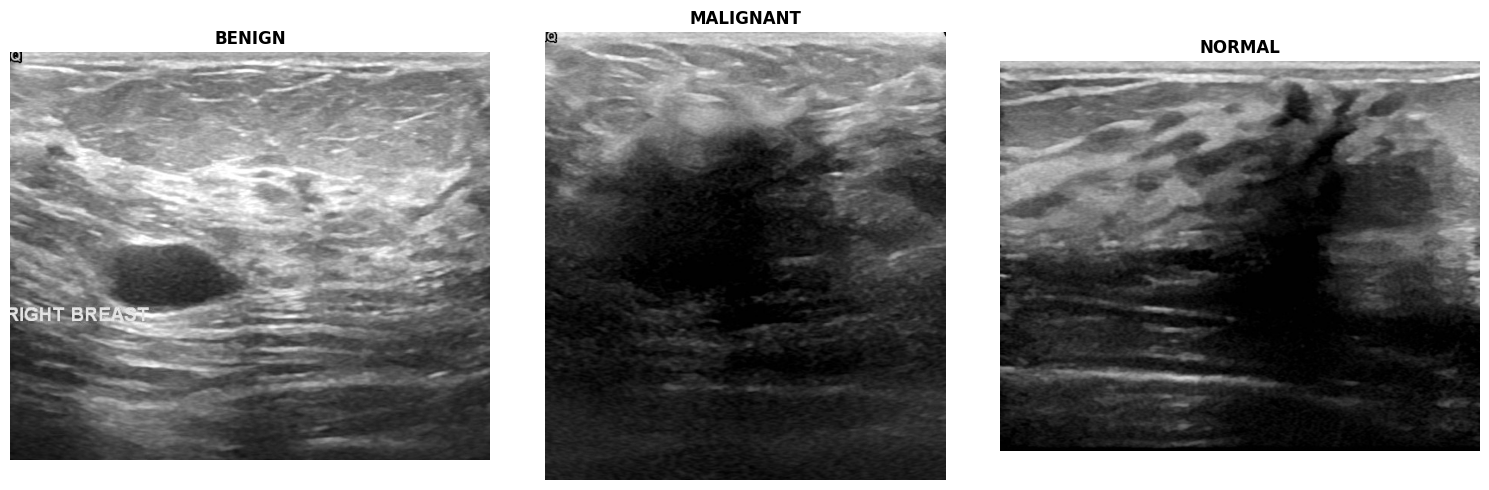

In [5]:
# Explore dataset structure
print(f"Exploring dataset structure...\n")

classes = ['benign', 'malignant', 'normal']
image_counts = {}
sample_images = {}

for class_name in classes:
    class_path = os.path.join(DATASET_PATH, class_name)
    if os.path.exists(class_path):
        images = [f for f in os.listdir(class_path) if f.endswith(('.png')) and '_mask' not in f]
        image_counts[class_name] = len(images)
        sample_images[class_name] = images[:1] if images else []
        print(f"{class_name}: {len(images)} images")

print(f"\nTotal images: {sum(image_counts.values())}")

# Display sample images from each class
print("\n" + "="*60)
print("ULTRASOUND IMAGE CHARACTERISTICS")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, class_name in enumerate(classes):
    if sample_images[class_name]:
        img_path = os.path.join(DATASET_PATH, class_name, sample_images[class_name][0])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if img is not None:
            axes[idx].imshow(img, cmap='gray')
            axes[idx].set_title(f'{class_name.upper()}', fontsize=12, fontweight='bold')
            axes[idx].axis('off')
            
           

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'ultrasound_samples.png'), dpi=100, bbox_inches='tight')
plt.show()



## 3. Train/Test Split (Before Feature Extraction!)


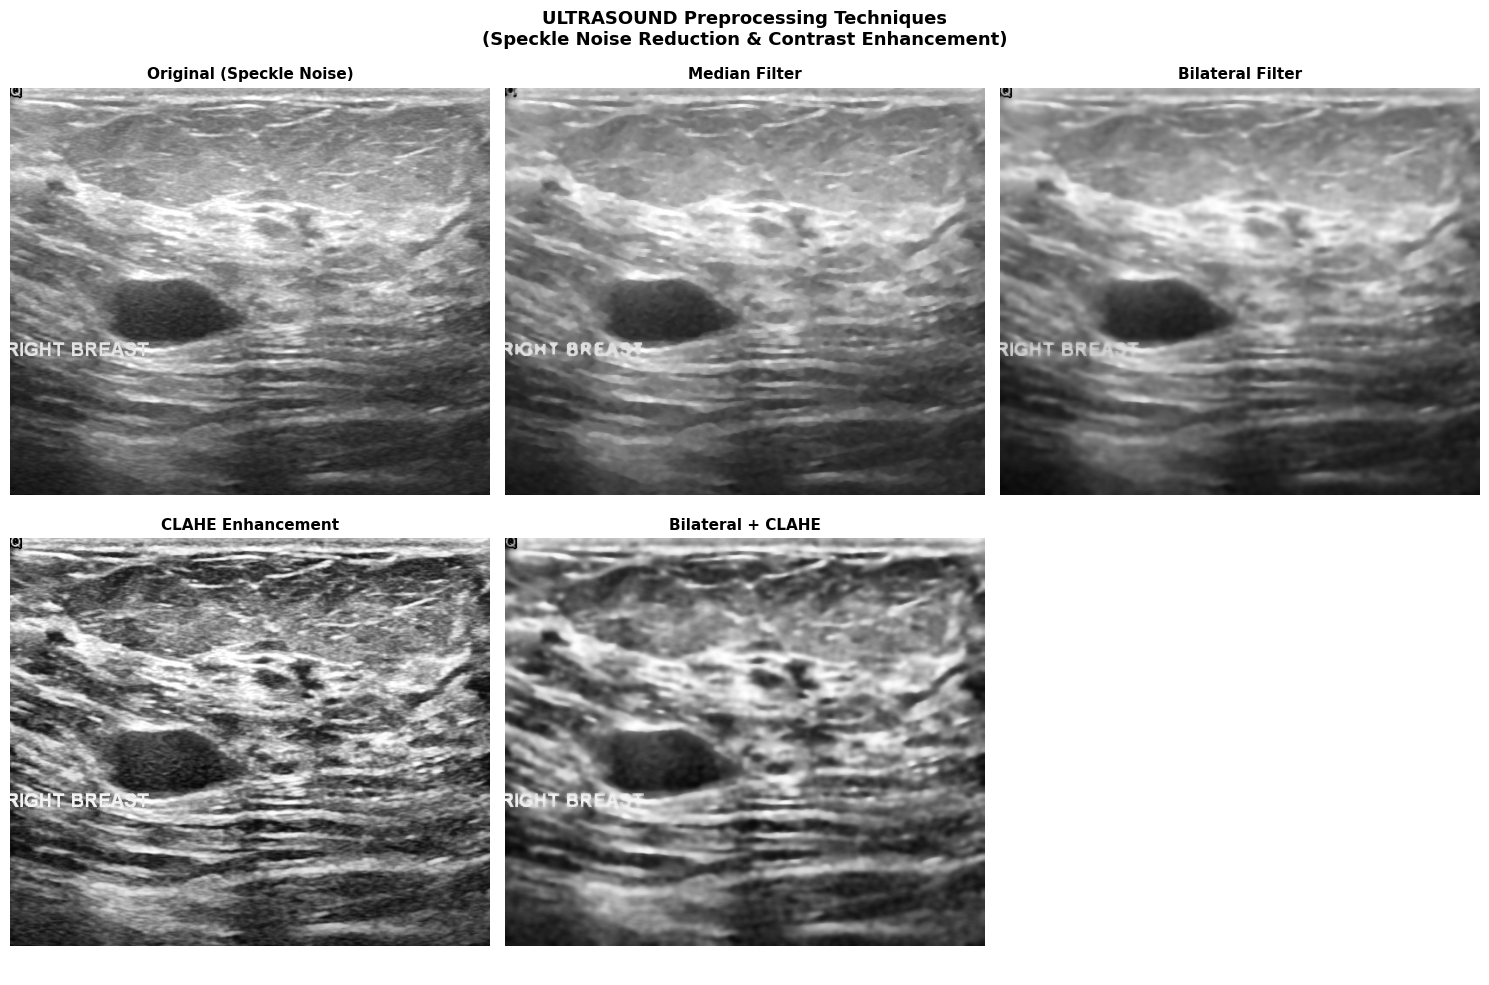

In [12]:
import matplotlib.patches as mpatches

# Demonstrate preprocessing on sample ultrasound
if sample_images['benign']:
    sample_path = os.path.join(DATASET_PATH, 'benign', sample_images['benign'][0])
    original = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)
    
    # Different preprocessing techniques
    median = cv2.medianBlur(original, 5)
    bilateral = cv2.bilateralFilter(original, 9, 75, 75)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(original)
    combined = clahe.apply(bilateral)
    
    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    images_to_show = [
        (original, 'Original (Speckle Noise)', 0),
        (median, 'Median Filter', 1),
        (bilateral, 'Bilateral Filter', 2),
        (enhanced, 'CLAHE Enhancement', 3),
        (combined, 'Bilateral + CLAHE', 4),
    ]
    
    for img, title, pos in images_to_show:
        row, col = pos // 3, pos % 3
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].set_title(title, fontsize=11, fontweight='bold')
        axes[row, col].axis('off')
        
     
    
    # Hide last subplot
    axes[1, 2].axis('off')
    
    plt.suptitle('ULTRASOUND Preprocessing Techniques\n(Speckle Noise Reduction & Contrast Enhancement)',
                fontsize=13, fontweight='bold', y=0.98)
    plt.tight_layout()
    #plt.savefig(os.path.join(OUTPUT_PATH, 'ultrasound_preprocessing.png'), dpi=100, bbox_inches='tight')
    plt.show()
    


In [11]:
from sklearn.model_selection import train_test_split
import shutil

# Create dataset index with file paths and labels
dataset_index = []

for class_name in classes:
    class_path = os.path.join(DATASET_PATH, class_name)
    if os.path.exists(class_path):
        # Only include non-mask images
        images = [f for f in os.listdir(class_path) 
                 if f.endswith(('.png')) and '_mask' not in f]
        for img in images:
            dataset_index.append({
                'filename': img,
                'class': class_name,
                'path': os.path.join(class_path, img)
            })

# Convert to DataFrame
df_dataset = pd.DataFrame(dataset_index)
print(f"Total images found: {len(df_dataset)}")
print(f"\nClass distribution:\n{df_dataset['class'].value_counts()}\n")

# Stratified train/test split (80-20)
df_train, df_test = train_test_split(
    df_dataset,
    test_size=0.2,
    stratify=df_dataset['class'],
    random_state=42
)

print(f"Training set: {len(df_train)} images")
print(f"Test set: {len(df_test)} images")
print(f"\nTrain class distribution:\n{df_train['class'].value_counts()}")
print(f"\nTest class distribution:\n{df_test['class'].value_counts()}")


Total images found: 780

Class distribution:
class
benign       437
malignant    210
normal       133
Name: count, dtype: int64

Training set: 624 images
Test set: 156 images

Train class distribution:
class
benign       350
malignant    168
normal       106
Name: count, dtype: int64

Test class distribution:
class
benign       87
malignant    42
normal       27
Name: count, dtype: int64


## 4. Feature Extraction Functions
### Multiple Feature Types for Classification


In [13]:
from skimage import feature, measure, filters
from scipy import stats

def extract_statistical_features(image):
    """Extract basic statistical features"""
    return {
        'mean_intensity': np.mean(image),
        'std_intensity': np.std(image),
        'median_intensity': np.median(image),
        'min_intensity': np.min(image),
        'max_intensity': np.max(image),
        'entropy': -np.sum((np.histogram(image, bins=256)[0] / image.size) * 
                           np.log2(np.histogram(image, bins=256)[0] / image.size + 1e-10))
    }

def extract_texture_features(image):
    """Extract LBP (Local Binary Pattern) texture features"""
    lbp = feature.local_binary_pattern(image, P=8, R=1, method='uniform')
    hist, _ = np.histogram(lbp, bins=59, range=(0, 59))
    hist = hist.astype('float') / hist.sum()
    
    return {
        'lbp_mean': np.mean(lbp),
        'lbp_std': np.std(lbp),
        'lbp_hist_mean': np.mean(hist),
        'lbp_hist_std': np.std(hist),
    }

def extract_edge_features(image):
    """Extract edge-based features using Canny edge detection"""
    # Use OpenCV's Canny instead of skimage
    edges = cv2.Canny(image, 100, 200)
    edge_density = np.sum(edges > 0) / edges.size
    
    return {
        'edge_density': edge_density,
        'edge_count': np.sum(edges > 0),
        'edge_percentage': edge_density * 100
    }

def extract_shape_features(image):
    """Extract shape features using contours"""
    binary = (image > np.mean(image)).astype(np.uint8) * 255
    labeled = measure.label(binary)
    
    if labeled.max() == 0:
        return {
            'contour_area': 0,
            'contour_perimeter': 0,
            'circularity': 0,
            'eccentricity': 0
        }
    
    props = measure.regionprops(labeled)[0]
    
    return {
        'contour_area': props.area,
        'contour_perimeter': props.perimeter,
        'circularity': 4 * np.pi * props.area / (props.perimeter ** 2) if props.perimeter > 0 else 0,
        'eccentricity': props.eccentricity
    }

def extract_all_features(image_path):
    """Load image and extract all feature types"""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    
    features = {}
    features.update(extract_statistical_features(img))
    features.update(extract_texture_features(img))
    features.update(extract_edge_features(img))
    features.update(extract_shape_features(img))
    
    return features

print("\nFeature types being extracted:")
print("  1. Statistical (mean, std, entropy)")
print("  2. Texture (LBP - Local Binary Pattern)")
print("  3. Edge (Canny edge detection via OpenCV)")
print("  4. Shape (Area, perimeter, circularity, eccentricity)")



Feature types being extracted:
  1. Statistical (mean, std, entropy)
  2. Texture (LBP - Local Binary Pattern)
  3. Edge (Canny edge detection via OpenCV)
  4. Shape (Area, perimeter, circularity, eccentricity)


## 5. Extract Features from Train & Test Sets


In [16]:
def extract_features_from_dataframe(df, set_name="Dataset"):
    """Extract features for all images in dataframe"""
    features_list = []
    
    print(f"\nExtracting features from {set_name}...")
    for idx, row in df.iterrows():
        try:
            features = extract_all_features(row['path'])
            if features is not None:
                features['filename'] = row['filename']
                features['class'] = row['class']
                features_list.append(features)
            
            if (idx + 1) % 20 == 0:
                print(f"  Processed: {idx + 1}/{len(df)}")
        except Exception as e:
            print(f"  Error processing {row['filename']}: {str(e)}")
            continue
    
    df_features = pd.DataFrame(features_list)
    print(f"✓ Extracted {len(df_features)} feature sets from {set_name}")
    return df_features

# Extract features from train set
df_train_features = extract_features_from_dataframe(df_train, "Training Set")

# Extract features from test set
df_test_features = extract_features_from_dataframe(df_test, "Test Set")

# Display first few rows and summary statistics
print("\n" + "="*60)
print("Training Features Summary:")
print(df_train_features.head())
print(f"\nShape: {df_train_features.shape}")



Extracting features from Training Set...
  Processed: 140/624
  Processed: 220/624
  Processed: 80/624
  Processed: 520/624
  Processed: 600/624
  Processed: 380/624
  Processed: 660/624
  Processed: 60/624
  Processed: 620/624
  Processed: 120/624
  Processed: 780/624
  Processed: 160/624
  Processed: 720/624
  Processed: 680/624
  Processed: 240/624
  Processed: 640/624
  Processed: 580/624
  Processed: 440/624
  Processed: 700/624
  Processed: 540/624
  Processed: 740/624
  Processed: 200/624
  Processed: 40/624
  Processed: 480/624
  Processed: 560/624
  Processed: 180/624
  Processed: 20/624
  Processed: 280/624
  Processed: 300/624
  Processed: 500/624
✓ Extracted 624 feature sets from Training Set

Extracting features from Test Set...
  Processed: 340/156
  Processed: 400/156
  Processed: 460/156
  Processed: 320/156
  Processed: 100/156
  Processed: 760/156
  Processed: 420/156
  Processed: 260/156
  Processed: 360/156
✓ Extracted 156 feature sets from Test Set

Training Featu